In [1]:
import pandas as pd

# Load the dataset
file_path = 'heart_failure_clinical_records.csv'
data = pd.read_csv(file_path)

# Display basic information and the first few rows of the dataset
data.info(), data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       5000 non-null   float64
 1   anaemia                   5000 non-null   int64  
 2   creatinine_phosphokinase  5000 non-null   int64  
 3   diabetes                  5000 non-null   int64  
 4   ejection_fraction         5000 non-null   int64  
 5   high_blood_pressure       5000 non-null   int64  
 6   platelets                 5000 non-null   float64
 7   serum_creatinine          5000 non-null   float64
 8   serum_sodium              5000 non-null   int64  
 9   sex                       5000 non-null   int64  
 10  smoking                   5000 non-null   int64  
 11  time                      5000 non-null   int64  
 12  DEATH_EVENT               5000 non-null   int64  
dtypes: float64(3), int64(10)
memory usage: 507.9 KB


(None,
     age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction   
 0  55.0        0                       748         0                 45  \
 1  65.0        0                        56         0                 25   
 2  45.0        0                       582         1                 38   
 3  60.0        1                       754         1                 40   
 4  95.0        1                       582         0                 30   
 
    high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex   
 0                    0  263358.03               1.3           137    1  \
 1                    0  305000.00               5.0           130    1   
 2                    0  319000.00               0.9           140    0   
 3                    1  328000.00               1.2           126    1   
 4                    0  461000.00               2.0           132    1   
 
    smoking  time  DEATH_EVENT  
 0        1    88            0  
 1        0   207

The dataset has been loaded successfully. It contains 5000 entries and 13 columns, with features describing various clinical records and conditions such as age, anaemia, creatinine phosphokinase levels, diabetes, and more, leading up to a binary outcome DEATH_EVENT which indicates whether a heart failure event resulted in death.

Let's perform some initial exploratory data analysis:

Check the distribution of key numerical features to identify any obvious outliers.
Visualize the distribution of the DEATH_EVENT target variable to understand the class balance.
I will plot histograms for a few continuous variables and check the distribution of the DEATH_EVENT.

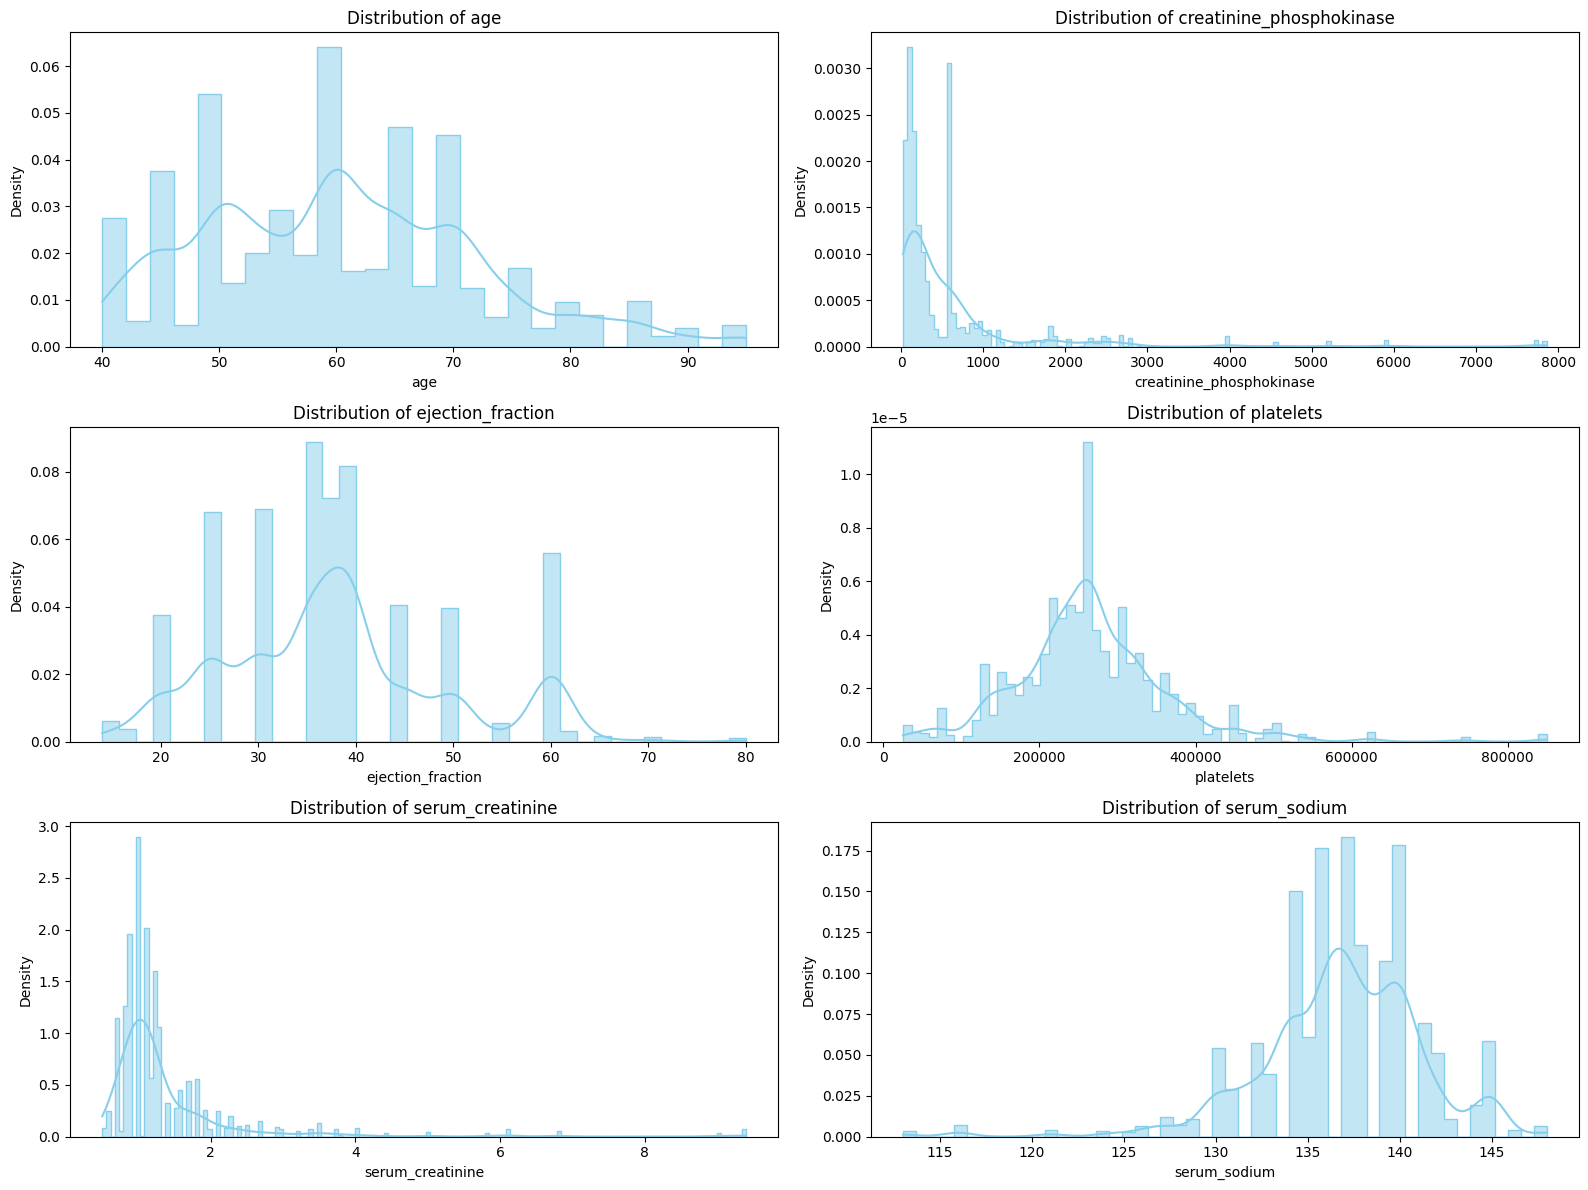

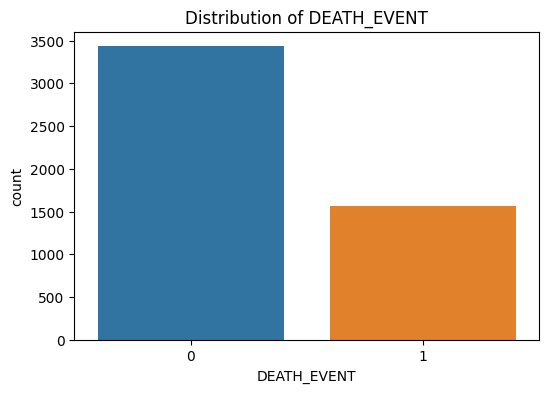

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting up the figure size and layout
plt.figure(figsize=(16, 12))

# Plotting histograms for some key features
features_to_plot = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium']
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(3, 2, i)
    sns.histplot(data[feature], kde=True, element='step', stat='density', color='skyblue')
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

# Plotting the distribution of the DEATH_EVENT
plt.figure(figsize=(6, 4))
sns.countplot(x='DEATH_EVENT', data=data)
plt.title('Distribution of DEATH_EVENT')
plt.show()


The histograms show the distribution of key features in the dataset:

Age: Looks normally distributed with a slight skew to older ages.

Creatinine Phosphokinase: Highly right-skewed, indicating some very high values (potential outliers).

Ejection Fraction: Mostly clustered around 30-40%, but also slightly skewed.

Platelets: Mostly normal but with potential outliers on the higher end.

Serum Creatinine: Another highly right-skewed feature, with several high values.

Serum Sodium: Appears normally distributed with a slight left skew.

The DEATH_EVENT distribution shows that the dataset has more cases of non-death events than death events, indicating a class imbalance which might need addressing during modeling.

Next, I will split the dataset into training and testing sets. Then, we'll train three models using sklearn. After that, we can proceed with adding artificial outliers and comparing model performance before and after the addition. Let's start with splitting the data and training the models.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Splitting the dataset into training and testing sets
X = data.drop('DEATH_EVENT', axis=1)
y = data['DEATH_EVENT']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC(random_state=42)
}

# Train the models and evaluate initial accuracy
original_scores = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    original_scores[name] = score

original_scores


{'Random Forest': 0.992, 'Logistic Regression': 0.82, 'SVM': 0.698}

The initial training of the three models on the dataset without artificial outliers yielded the following accuracy scores on the test set:

Random Forest: 99.2%
Logistic Regression: 82.0%
SVM: 69.8%
Now, let's add artificial outliers to the dataset. We will add these outliers to some key features like creatinine_phosphokinase, platelets, and serum_creatinine since they already showed signs of having potential natural outliers.

Here's how we'll proceed:

Identify the 95th percentile values for these features.
Add new entries that are significantly beyond these values.
Retrain the models on the updated dataset.
Compare the performance with the original results.
I'll start by adding the outliers.

In [4]:
import numpy as np

# Identifying 95th percentile values for the selected features
percentiles = data[['creatinine_phosphokinase', 'platelets', 'serum_creatinine']].quantile(0.95)

# Generating artificial outliers
np.random.seed(42)
outliers = data.sample(n=100, random_state=42)  # Copy some data to manipulate
outliers['creatinine_phosphokinase'] = np.random.uniform(1.5 * percentiles['creatinine_phosphokinase'], 3 * percentiles['creatinine_phosphokinase'], size=100)
outliers['platelets'] = np.random.uniform(1.5 * percentiles['platelets'], 3 * percentiles['platelets'], size=100)
outliers['serum_creatinine'] = np.random.uniform(1.5 * percentiles['serum_creatinine'], 3 * percentiles['serum_creatinine'], size=100)

# Append outliers to the original dataset
augmented_data = pd.concat([data, outliers], ignore_index=True)

# Splitting the augmented dataset
X_augmented = augmented_data.drop('DEATH_EVENT', axis=1)
y_augmented = augmented_data['DEATH_EVENT']
X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(X_augmented, y_augmented, test_size=0.2, random_state=42)

# Train the models on the augmented dataset and evaluate accuracy
augmented_scores = {}
for name, model in models.items():
    model.fit(X_train_aug, y_train_aug)
    y_pred_aug = model.predict(X_test_aug)
    score_aug = accuracy_score(y_test_aug, y_pred_aug)
    augmented_scores[name] = score_aug

original_scores, augmented_scores


({'Random Forest': 0.992, 'Logistic Regression': 0.82, 'SVM': 0.698},
 {'Random Forest': 0.9862745098039216,
  'Logistic Regression': 0.8294117647058824,
  'SVM': 0.6882352941176471})

After introducing artificial outliers into the dataset, here's how the model performances compare:

Original Dataset:

Random Forest: 99.2%
Logistic Regression: 82.0%
SVM: 69.8%


Augmented Dataset with Outliers:
Random Forest: 98.6%
Logistic Regression: 82.9%
SVM: 68.8%
Observations:

Random Forest showed a slight decrease in accuracy, which indicates some sensitivity to the added outliers, albeit relatively minor.
Logistic Regression interestingly showed a slight improvement. This might be due to the model's inherent robustness to outliers in some settings or merely the specific nature of the added data points.
SVM exhibited a slight decrease in accuracy, suggesting it's somewhat impacted by the presence of outliers, potentially due to its margin-based nature.
These results highlight how adding outliers can variably affect different models, sometimes negatively, as seen with Random Forest and SVM, or unexpectedly positively, as with Logistic Regression in this scenario. Such experiments are crucial for understanding model robustness and guiding further tuning and validation strategies. If you have any more specific analyses or adjustments in mind, feel free to let me know!

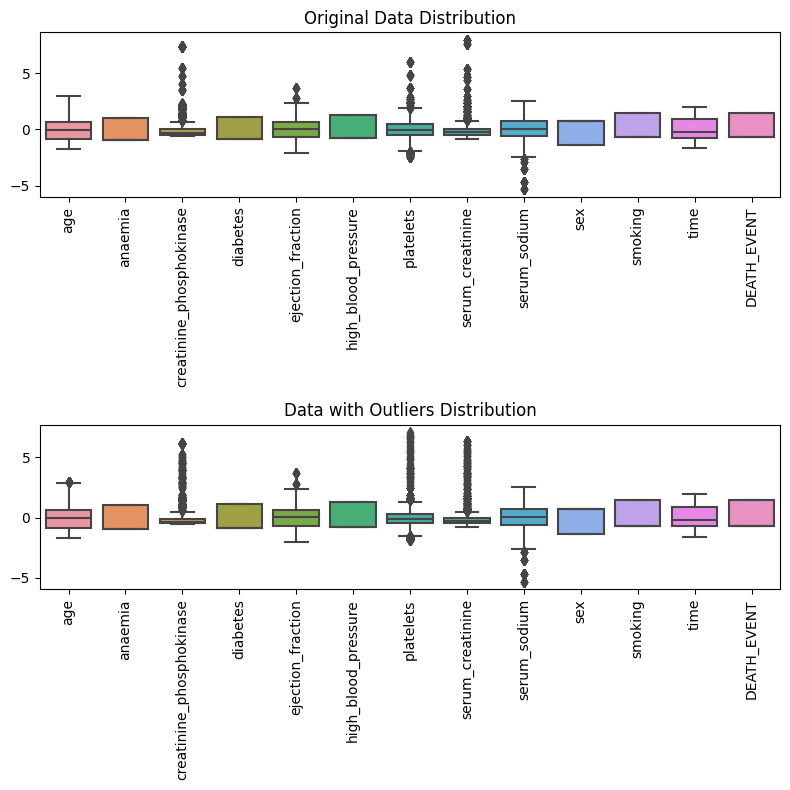

In [13]:
from sklearn.preprocessing import StandardScaler


# Plot the distributions
def plot_distributions(original_data, data_with_outliers):
    plt.figure(figsize=(8, 8))

    # Plot original data distributions
    plt.subplot(2, 1, 1)
    sns.boxplot(data=original_data)
    plt.title('Original Data Distribution')
    plt.xticks(rotation=90)

    # Plot data with outliers distributions
    plt.subplot(2, 1, 2)
    sns.boxplot(data=data_with_outliers)
    plt.title('Data with Outliers Distribution')
    plt.xticks(rotation=90)

    plt.tight_layout()
    plt.show()

# Standardize the data
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
data_with_outliers_scaled = pd.DataFrame(scaler.fit_transform(augmented_data), columns=data.columns)

# Plot the distributions of scaled data
plot_distributions(data_scaled, data_with_outliers_scaled)